In [1]:
%install-location /notebooks/language2motion.gt/swift-install
%install-swiftpm-flags -c release
%install '.package(path: "/notebooks/language2motion.gt/code")' Datasets

Installing packages:
	.package(path: "/notebooks/language2motion.gt/code")
		Datasets
With SwiftPM flags: ['-c', 'release']
Working in: /tmp/tmp_xhq43sk/swift-install
[1/2] Compiling Datasets ArrayUtils.swift
[2/3] Compiling jupyterInstalledPackages jupyterInstalledPackages.swift
[3/3] Linking libjupyterInstalledPackages.so
Initializing Swift...
Installation complete!


In [2]:
import Foundation
import TensorFlow
import PythonKit

import Datasets

In [3]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [4]:
let pd = Python.import("pandas")
let np = Python.import("numpy")
let plt = Python.import("matplotlib.pyplot")

In [31]:
let dataURL = URL(fileURLWithPath: "/notebooks/language2motion.gt/data/")
// let serializedDatasetURL = dataURL.appendingPathComponent("motion_dataset.motion_flag.normalized.plist")
let serializedDatasetURL = dataURL.appendingPathComponent("motion_dataset.motion_flag.normalized.downsampled.39102.plist")
let labelsURL = dataURL.appendingPathComponent("labels_ds_v2.csv")

In [32]:
let dataset = try! Motion2Label(
    serializedDatasetURL: serializedDatasetURL,
    labelsURL: labelsURL,
    maxSequenceLength: 1000,
    batchSize: 10
) { 
    // TODO: move this to dataset class
    (example: Motion2LabelExample) -> LabeledMotionBatch in
    let motionFrames = Tensor<Float>(example.motionSample.motionFramesArray)
    let motionFlag = Tensor<Int32>(motionFrames[0..., 44...44].squeezingShape(at: 1))
    let origMotionFramesCount = Tensor<Int32>(Int32(motionFrames.shape[0]))
    let motionBatch = MotionBatch(motionFrames: motionFrames, motionFlag: motionFlag, origMotionFramesCount: origMotionFramesCount)
    let label = Tensor<Int32>(Int32(example.label!.idx))
    return LabeledMotionBatch(data: motionBatch, label: label)
}

MotionDataset(motionSamples: 39102)


In [33]:
let motionDataset = dataset.motionDataset

In [34]:
let df = pd.read_csv(labelsURL.path)
df.count

3012


In [35]:
// filter out samples without annotations
let motionSamples = motionDataset.motionSamples.filter { $0.annotations.count > 0 }

In [36]:
let motionLengths = motionSamples.map { $0.motionFramesArray.shape[0] }
motionLengths.count

30120


# "Walking backwards" stats

In [37]:
dataset.labels

▿ 5 elements
  - 0 : "Doing something"
  - 1 : "Walking and turning"
  - 2 : "Walking backwards"
  - 3 : "Walking few steps"
  - 4 : "Walking or running"


In [38]:
let walkingBackwardsSamples = motionSamples.filter { dataset.getLabel($0.sampleID)!.label == "Walking backwards" }
let walkingBackwardsLengths = walkingBackwardsSamples.map { $0.motionFramesArray.shape[0] }
(walkingBackwardsSamples.count, Python.max(walkingBackwardsLengths))

▿ 2 elements
  - .0 : 1030
  - .1 : 500


In [39]:
Python.max(walkingBackwardsLengths)

500


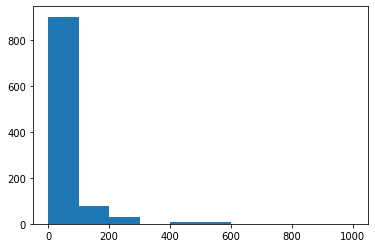

None


In [40]:
plt.hist(walkingBackwardsLengths, bins: 10, range: [0, 10*100])
plt.show()

In [41]:
for x in plt.hist(walkingBackwardsLengths, bins: 10, range: [0, 10*100])[0] {
    print(x)
}

901.0
79.0
30.0
0.0
10.0
10.0
0.0
0.0
0.0
0.0


# Annotated dataset stats

In [42]:
Python.max(motionLengths)

500


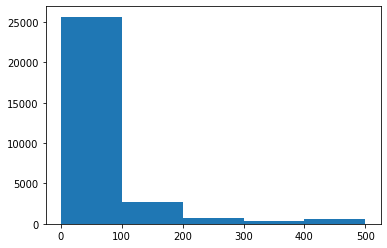

None


In [44]:
plt.hist(motionLengths, bins: 5, range: [0, 5*100])
plt.show()

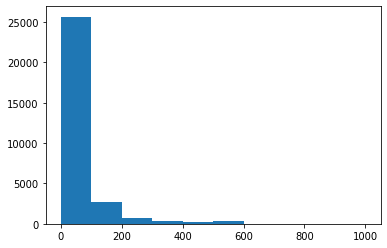

None


In [46]:
plt.hist(motionLengths, bins: 10, range: [0, 10*100])
plt.show()

In [47]:
for x in plt.hist(motionLengths, bins: 10, range: [0, 10*100])[0] {
    print(x)
}

25666.0
2744.0
693.0
397.0
250.0
370.0
0.0
0.0
0.0
0.0
